In [1]:
%matplotlib inline
# %matplotlib notebook
import pandas as pd
import DataHelper
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
e = DataHelper.eclass_data()

In [3]:
e.cis.Q15.unique()

array([nan, '4 year college', "Master's granting institution",
       'PhD granting institution', '2 year college'], dtype=object)

In [4]:
def return_race(rcode):
    """
    Returns the racial identifier from IPEDS definitions
    
    All 'unknown' columns are reduced to 'Not Reported'
    
    'American Indian or Alaska Native' and 'Native Hawaiian or other Pacific Islander'
    are counted as 'Not Reported' due to the very low numbers (<100) of data gathered for
    them it will not be fair to characterize results of these students
    """
    race_codes = {
#         '10000000':'American Indian or Alaska Native'
        '10000000':'Not Reported'
                  , '01000000':'Asian'
                  , '00100000':'Black'
                  , '00010000':'Hispanic/Latino'
#                   , '00001000':'Native Hawaiian or other Pacific Islander'
                  , '00001000':'Not Reported'
                  , '00000100':'White'
                 }
    try:
        return race_codes[rcode]
    except KeyError:
        return 'Not Reported'

races = e.post.set_index('anon_student_id')[[ 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7', 'race_unknown']].fillna(0).astype(int).astype(str)

races = (races[ 'Q52_1'] + races['Q52_2'] + races['Q52_3'] + races['Q52_4'] + races['Q52_5'] + races['Q52_6'] + races['Q52_7'] + races['race_unknown'])    

races = races.apply(return_race)
races = pd.DataFrame({'Race':races})


In [5]:
gender = e.post[['anon_student_id','Q54']].drop_duplicates().set_index('anon_student_id')#
gender.columns = ['Gender']

In [6]:
buffy_student = pd.DataFrame(index=pd.concat([e.get_buffy_pre(), e.get_buffy_post()]).anon_student_id.unique())
buffy_student['BUFFY'] = 1

In [7]:
future_plans = e.post[['anon_student_id', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7', 'Q53_8']].set_index('anon_student_id')

In [8]:
index = np.arange(0, pd.concat([e.pre.anon_student_id, e.post.anon_student_id]).max()+1, 1)
students = pd.DataFrame(index=index)

students = students.join(races, how='left').join(gender, how='left').join(buffy_student, how='left').join(future_plans).reset_index()
students = students.drop_duplicates(subset=['index'], keep='first').set_index('index').dropna(how='all')
students['BUFFY'] = students['BUFFY'].fillna(0)
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [9]:
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']]

,Q15,anon_instructor_id,anon_university_id,ResponseId
0,NaN,0,0,R_5vvkiNRDrvutGdX
1,4 year college,1,1,R_5mXbzVvsHehQ07L
2,NaN,1,1,R_1g28mGAPrOOZ4Mh
3,4 year college,2,1,R_1pL1oZ2Un6TQfkp
4,4 year college,3,2,R_2ritbcOI1sEN5mn
...,...,...,...,...
594,4 year college,203,132,R_3qJOKOP2r5VyMrj
595,PhD granting institution,69,32,R_3nu6XUP5nAi4lZe
596,NaN,69,32,R_qITeC301YGuhQNr
597,NaN,69,32,R_A72jufifWSmfboZ


In [11]:
alldata = pd.concat([e.pre, e.post])
cis_connector = alldata[['anon_student_id', 'ResponseId']].drop_duplicates().drop_duplicates(subset='anon_student_id').set_index('anon_student_id')
students = students.join(cis_connector).merge(e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']])

In [12]:
# data = pd.get_dummies(students)
# data.dropna(inplace=True)

In [13]:
cols = ['Race', 'Gender', 'BUFFY', 'Q53_1', 'Q53_2','Q53_3','Q53_4','Q53_5','Q53_6','Q53_7','Q53_8','Q15','anon_instructor_id','anon_university_id']

pd.get_dummies(students[cols]).columns

Index(['Gender', 'BUFFY', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8', 'anon_instructor_id', 'anon_university_id',
       'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino', 'Race_Not Reported',
       'Race_White', 'Q15_2 year college', 'Q15_4 year college',
       'Q15_Master's granting institution', 'Q15_PhD granting institution'],
      dtype='object')

In [14]:
xcols = ['Gender', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8'
#          , 'anon_instructor_id', 'anon_university_id','Race_American Indian or Alaska Native'
         , 'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino'
#        'Race_Native Hawaiian or other Pacific Islander'
         , 'Race_Not Reported'
         , 'Race_White'
#          , 'Q15_2 year college'
         , 'Q15_4 year college',
       "Q15_Master's granting institution", 'Q15_PhD granting institution']
ycol = 'BUFFY'

data = pd.get_dummies(students[cols])
data = data[data['Q15_2 year college']==0]
data.dropna(inplace=True)

# X_train, X_test, y_train, y_test = train_test_split(data[xcols], data[ycol])

In [43]:
KF = KFold(n_splits = 5, shuffle = True)

num_round = 30000
param = {'max_depth': 2, 'eta': 0.3, 'objective': 'reg:logistic'}
param['nthread'] = 18
param['eval_metric'] = 'auc'
# this might produce data leakage but for now i guess its okay
param['scale_pos_weight'] = data.BUFFY.count()/data.BUFFY.sum()

logreg = []
xgmod = []

lr_auc = []
xg_auc = []

n = 1

KF_index = KF.split(data)

trains = []
tests = []

# for train, test in KF.split(data):
for train, test in KF_index:
    trains.append(train)
    tests.append(test)
    
    X_train = data[xcols].iloc[train]
    y_train = data[ycol].iloc[train]
    
    X_test = data[xcols].iloc[test]
    y_test = data[ycol].iloc[test]
    
    logit_mod = sm.Logit(exog=X_train, endog=y_train)
    logit_res = logit_mod.fit()
#     preds = logit_res.predict(X_test)
    preds = logit_res.predict(X_test)
    logreg.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    lr_auc.append(auc)
    print('logreg k={n} fold AUC='.format(n=n), auc)
    
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
    dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

    bst = xgb.train(param, dtrain, num_round)
    
#     classify = lambda x: 0 if x < 0.5 else 1
#     preds = [classify(y) for y in bst.predict(dtest)]
#     xgmod.append(preds)
    preds = bst.predict(dtest)
    xgmod.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    print('xgboost k={n} fold AUC='.format(n=n), auc)
    xg_auc.append(auc)
    
    n += 1

Optimization terminated successfully.
         Current function value: 0.346110
         Iterations 7
logreg k=1 fold AUC= 0.7160543080736843
xgboost k=1 fold AUC= 0.7416030914213743
Optimization terminated successfully.
         Current function value: 0.345147
         Iterations 7
logreg k=2 fold AUC= 0.7156830587353252
xgboost k=2 fold AUC= 0.7395855714899608
Optimization terminated successfully.
         Current function value: 0.348163
         Iterations 7
logreg k=3 fold AUC= 0.7372329284037125
xgboost k=3 fold AUC= 0.7475262579707884
Optimization terminated successfully.
         Current function value: 0.346787
         Iterations 7
logreg k=4 fold AUC= 0.7389227206546986
xgboost k=4 fold AUC= 0.7636593004800051
Optimization terminated successfully.
         Current function value: 0.344519
         Iterations 7
logreg k=5 fold AUC= 0.7333463977904083
xgboost k=5 fold AUC= 0.74350541325733


In [44]:
np.mean(lr_auc)

0.7282478827315657

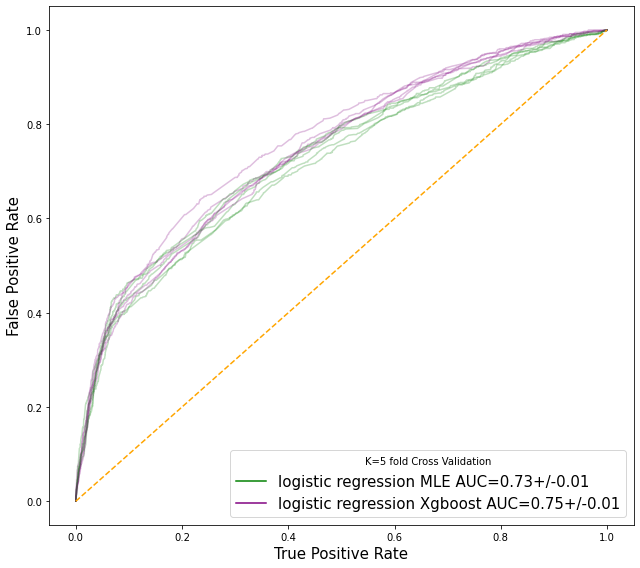

In [53]:
fig, ax = plt.subplots(figsize=(9, 8))

plt.plot([],[], color='green', label='logistic regression MLE AUC='+ str(np.mean(lr_auc).round(2))+ '+/-'+ str(np.std(lr_auc).round(2)))

plt.plot([],[], color='purple', label='logistic regression Xgboost AUC='+ str(np.mean(xg_auc).round(2))+ '+/-'+ str(np.std(xg_auc).round(2)))
ax.legend(fontsize=15, title='K=5 fold Cross Validation') 

for k in np.arange(0, 5, 1):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=logreg[k])
    ax.plot(fpr, tpr, color='green', alpha=0.25, label='K={k} fold logistic regression MLE'.format(k=k+1))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=xgmod[k])
    ax.plot(fpr, tpr, color='purple', alpha=0.25, label='K={k} fold logistic regression Xgboost'.format(k=k+1))
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--')
ax.set_ylabel('False Positive Rate', fontsize=15)
ax.set_xlabel('True Positive Rate', fontsize=15)
fig.tight_layout()

In [15]:
# logit_mod = sm.Logit(exog=X_train, endog=y_train)
# # logit_res = logit_mod.fit_regularized()
# logit_res = logit_mod.fit()
# logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.341295
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  BUFFY   No. Observations:                20532
Model:                          Logit   Df Residuals:                    20515
Method:                           MLE   Df Model:                           16
Date:                Thu, 03 Sep 2020   Pseudo R-squ.:                  0.1351
Time:                        11:51:32   Log-Likelihood:                -7007.5
converged:                       True   LL-Null:                       -8102.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Gender                                0.2416      0.045      5.324      0.000       0.153       0.330
Q53_1                                -2.0259      0.055    -36.587      0.000      -2.134      -1.917
Q53_2                                 0.1204      0.047      2.572      0.010       0.029       0.212
Q53_3                                -0.2741      0.049     -5.607      0.000      -0.370      -0.178
Q53_4                                 0.4193      0.065      6.496      0.000       0.293       0.546
Q53_5                                 0.0746      0.062      1.198      0.231      -0.047       0.197
Q53_6                                -0.3139      0.091     -3.447      0.001      -0.492      -0.135
Q53_7                                -0.0385      0.071     -0.541      0.588      -0.178       0.101
Q53_8                                -0.0161      0.072     -0.224      0.822      -0.157       0.125
Race_Asian                            1.6185      0.292      5.538      0.000       1.046       2.191
Race_Black                            0.8456      0.314      2.693      0.007       0.230       1.461
Race_Hispanic/Latino                  1.2267      0.306      4.014      0.000       0.628       1.826
Race_Not Reported                     1.5081      0.292      5.169      0.000       0.936       2.080
Race_White                            1.6914      0.290      5.830      0.000       1.123       2.260
Q15_4 year college                    0.6721      0.083      8.109      0.000       0.510       0.835
Q15_Master's granting institution    -0.9122      0.146     -6.240      0.000      -1.199      -0.626
Q15_PhD granting institution         -0.3834      0.053     -7.236      0.000      -0.487      -0.280
=====================================================================================================
"""

In [16]:
# preds = logit_res.predict(X_test)
# metrics.roc_auc_score(y_true=y_test, y_score=preds)

0.7246270046217669

In [17]:
# X_train.join(y_train)

,Gender,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,Race_Asian,Race_Black,Race_Hispanic/Latino,Race_Not Reported,Race_White,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution,BUFFY
16313,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,1,0,0,0,0.0
26101,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,0,1,0,0,0,0,0,0,0.0
7136,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,1,0,0,0,0.0
13351,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,1,0,0,1,1.0
23562,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12653,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,1,0,0,0,0,0,0.0
22658,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,1,0,0,1,0.0
27718,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,0,0,0,0,1,0,0,1,0.0
2945,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,0,1,0.0


In [18]:
# dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
# dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

# # param = {'max_depth': 5, 'eta': 0.3, 'objective': 'binary:logistic'}
# param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:logistic'}
# # param = {'max_depth': 2, 'booster': 'gblinear', 'objective': 'binary:logistic'}
# param['nthread'] = 4
# param['eval_metric'] = 'auc'
# param['scale_pos_weight'] = data.BUFFY.count()/data.BUFFY.sum()

# num_round = 30000
# bst = xgb.train(param, dtrain, num_round)

In [19]:
# classify = lambda x: 0 if x < 0.5 else 1
# preds = [classify(y) for y in bst.predict(dtest)]
# metrics.roc_auc_score(y_true=y_test, y_score=preds)

0.6447667539048362

In [20]:
# xgb.plot_importance(bst)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [21]:
# np.sqrt(17)

4.123105625617661

In [22]:
# data.corr()

,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,...,anon_university_id,Race_Asian,Race_Black,Race_Hispanic/Latino,Race_Not Reported,Race_White,Q15_2 year college,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution
Gender,1.000000,0.075698,-0.102431,0.040716,-0.091278,0.186526,0.152434,0.010693,-0.040307,-0.044895,...,-0.040924,-0.008544,-0.069862,0.029746,0.011244,0.016643,NaN,-0.009385,0.046529,0.006987
BUFFY,0.075698,1.000000,-0.342158,-0.002919,-0.074834,0.097884,0.029003,-0.068530,-0.104819,-0.027369,...,0.020600,0.000242,-0.058696,-0.031742,-0.001546,0.044223,NaN,0.093254,-0.046490,-0.042988
Q53_1,-0.102431,-0.342158,1.000000,0.039107,0.100621,-0.135924,-0.057607,0.114212,0.274854,0.034723,...,0.018761,0.005590,0.048101,0.013309,-0.031056,-0.011324,NaN,-0.071389,0.021882,-0.031774
Q53_2,0.040716,-0.002919,0.039107,1.000000,0.177033,-0.047722,0.044323,0.067334,0.192734,-0.017796,...,-0.004606,-0.022110,0.024037,0.010002,-0.000438,0.001776,NaN,-0.022655,0.008549,-0.009571
Q53_3,-0.091278,-0.074834,0.100621,0.177033,1.000000,-0.198945,-0.011092,0.076063,0.094233,0.183830,...,0.021421,0.038346,0.047725,0.014712,0.002987,-0.062527,NaN,0.000285,-0.000428,-0.050401
Q53_4,0.186526,0.097884,-0.135924,-0.047722,-0.198945,1.000000,-0.018577,-0.050845,-0.067873,-0.091679,...,-0.044601,0.004212,-0.069092,0.017894,0.004822,0.016591,NaN,0.008357,0.062553,0.008063
Q53_5,0.152434,0.029003,-0.057607,0.044323,-0.011092,-0.018577,1.000000,0.016004,0.009114,0.106629,...,-0.004673,0.018523,-0.047525,0.031331,0.004065,-0.011119,NaN,-0.014784,0.043543,0.030170
Q53_6,0.010693,-0.068530,0.114212,0.067334,0.076063,-0.050845,0.016004,1.000000,0.345741,0.095475,...,0.006740,0.001207,0.010197,-0.025549,-0.010296,0.014393,NaN,-0.015198,-0.012959,-0.012238
Q53_7,-0.040307,-0.104819,0.274854,0.192734,0.094233,-0.067873,0.009114,0.345741,1.000000,0.070721,...,0.015283,-0.014205,0.025102,-0.011191,-0.028503,0.025674,NaN,-0.001650,-0.015485,-0.021257
Q53_8,-0.044895,-0.027369,0.034723,-0.017796,0.183830,-0.091679,0.106629,0.095475,0.070721,1.000000,...,0.001889,-0.010391,0.005138,0.011620,-0.013168,0.009579,NaN,-0.013013,0.003948,-0.015449


In [23]:
# students.groupby(['Race', 'Gender', 'BUFFY']).count()/students.groupby(['Race', 'Gender']).count()

BUFFY       Q15     Q53_1     Q53_2     Q53_3  \
Race            Gender BUFFY                                                  
Asian           1.0    0.0      NaN  0.906032  0.892068  0.892068  0.892068   
                       1.0      NaN  0.093968  0.107932  0.107932  0.107932   
                2.0    0.0      NaN  0.878049  0.843938  0.843938  0.843938   
                       1.0      NaN  0.121951  0.156062  0.156062  0.156062   
                3.0    0.0      NaN  0.900000  0.785714  0.785714  0.785714   
                       1.0      NaN  0.100000  0.214286  0.214286  0.214286   
Black           1.0    0.0      NaN  0.945701  0.961883  0.961883  0.961883   
                       1.0      NaN  0.054299  0.038117  0.038117  0.038117   
                2.0    0.0      NaN  0.907216  0.923851  0.923851  0.923851   
                       1.0      NaN  0.092784  0.076149  0.076149  0.076149   
                3.0    0.0      NaN  0.800000  0.900000  0.900000  0.900000   
                       1.0      NaN  0.200000  0.100000  0.100000  0.100000   
Hispanic/Latino 1.0    0.0      NaN  0.955696  0.923313  0.923313  0.923313   
                       1.0      NaN  0.044304  0.076687  0.076687  0.076687   
                2.0    0.0      NaN  0.940870  0.896283  0.896283  0.896283   
                       1.0      NaN  0.059130  0.103717  0.103717  0.103717   
                3.0    0.0      NaN  1.000000  0.733333  0.733333  0.733333   
                       1.0      NaN  0.000000  0.266667  0.266667  0.266667   
Not Reported    1.0    0.0      NaN  0.892077  0.897260  0.897260  0.897260   
                       1.0      NaN  0.107923  0.102740  0.102740  0.102740   
                2.0    0.0      NaN  0.863089  0.847252  0.847252  0.847252   
                       1.0      NaN  0.136911  0.152748  0.152748  0.152748   
                3.0    0.0      NaN  0.837838  0.743363  0.743363  0.743363   
                       1.0      NaN  0.162162  0.256637  0.256637  0.256637   
White           1.0    0.0      NaN  0.862735  0.880620  0.880620  0.880620   
                       1.0      NaN  0.137265  0.119380  0.119380  0.119380   
                2.0    0.0      NaN  0.841799  0.828994  0.828994  0.828994   
                       1.0      NaN  0.158201  0.171006  0.171006  0.171006   
                3.0    0.0      NaN  0.880000  0.833333  0.833333  0.833333   
                       1.0      NaN  0.120000  0.166667  0.166667  0.166667   

                                 Q53_4     Q53_5     Q53_6     Q53_7  \
Race            Gender BUFFY                                           
Asian           1.0    0.0    0.892068  0.892068  0.892068  0.892068   
                       1.0    0.107932  0.107932  0.107932  0.107932   
                2.0    0.0    0.843938  0.843938  0.843938  0.843938   
                       1.0    0.156062  0.156062  0.156062  0.156062   
                3.0    0.0    0.785714  0.785714  0.785714  0.785714   
                       1.0    0.214286  0.214286  0.214286  0.214286   
Black           1.0    0.0    0.961883  0.961883  0.961883  0.961883   
                       1.0    0.038117  0.038117  0.038117  0.038117   
                2.0    0.0    0.923851  0.923851  0.923851  0.923851   
                       1.0    0.076149  0.076149  0.076149  0.076149   
                3.0    0.0    0.900000  0.900000  0.900000  0.900000   
                       1.0    0.100000  0.100000  0.100000  0.100000   
Hispanic/Latino 1.0    0.0    0.923313  0.923313  0.923313  0.923313   
                       1.0    0.076687  0.076687  0.076687  0.076687   
                2.0    0.0    0.896283  0.896283  0.896283  0.896283   
                       1.0    0.103717  0.103717  0.103717  0.103717   
                3.0    0.0    0.733333  0.733333  0.733333  0.733333   
                       1.0    0.266667  0.266667  0.266667  0.266667   
Not Reported    1.0    0.0    0.897260  0.897260  0.897260  0